In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

In [3]:
#obtain similar results every time
ensure_reproducibility(42)

<h3> Exploratory analysis </h3>

Parse the dataset to obtain the $E$, $p_T$, $\eta$ and $\phi$ values for every jet ('$j$') object. Some events have no jets, while some have multiple jets.

In [4]:
jets_df = parse_csv("data/monojet_Zp2000.0_DM_50.0_chan3.csv")

At first glance, it is seen that the scales of the four variables vary widely, necessitating some preprocessing.

In [5]:
print(jets_df.head()) 
print(f"There are {len(jets_df)} samples in the dataset.")

          E        pt       eta      phi
0  258722.0  243675.0  0.328962  2.25014
1  520092.0  108590.0 -2.247300 -1.85679
2  383024.0   88405.6  2.145160 -1.95635
3   39507.6   35365.1  0.470460 -1.16445
4  225430.0   26878.2 -2.816080 -2.25938
There are 22661 samples in the dataset.


$E$ and $p_T$ are seen to be strongly correlated. This is a good sign, as it is typically more difficult to compress sets of variables with a low correlation into a lower dimension.

In [6]:
jets_df.corr()

,E,pt,eta,phi
E,1.000000,0.708278,-0.017041,0.003013
pt,0.708278,1.000000,-0.007534,-0.002161
eta,-0.017041,-0.007534,1.000000,0.005108
phi,0.003013,-0.002161,0.005108,1.000000


Perform a 90-10 train-val split to analyze performance of the models.

In [7]:
jets_df_train, jets_df_val = train_test_split(jets_df, test_size=0.1)

In [8]:
#quick glance at the distribution of the variables
jets_df_train.describe()

,E,pt,eta,phi
count,2.039400e+04,2.039400e+04,20394.000000,20394.000000
mean,4.353153e+05,2.413652e+05,0.016228,-0.009750
std,4.268389e+05,2.656022e+05,1.502750,1.810270
min,2.437580e+04,2.208650e+04,-4.870110,-3.141560
25%,1.183988e+05,4.777460e+04,-0.953167,-1.579038
50%,2.920305e+05,1.226055e+05,0.016298,0.000925
75%,6.252135e+05,3.651080e+05,0.995496,1.542058
max,4.413680e+06,2.090860e+06,4.753080,3.141210


Visualizing the distribution of the variables, the difference in scale is evident. $E$ and $p_T$ are exponentially distributed, with values of the magnitude $10^{6}$ while $\eta$ and $\phi$ are more uniformly distributed around 0.

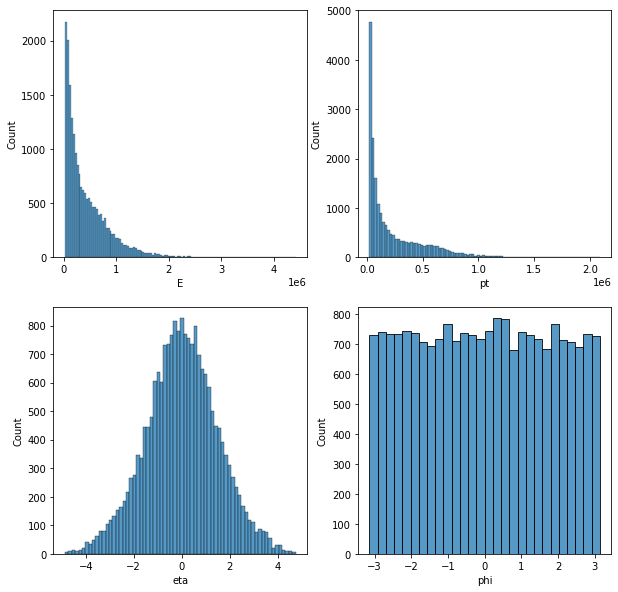

In [9]:
plot_dist(jets_df_train)

The variables are normalized such that the mean and standard deviation of each distribution are 0 and 1 respectively, and all variables are of the same order of magnitude. This equalizes the influence of each variable in the model and speeds up training. More sophisticated techniques such as log scaling were not found to noticably improve performance.

In [10]:
scaler = StandardScaler()
jets_df_train_norm = pd.DataFrame(scaler.fit_transform(jets_df_train), columns=['E_norm', 'pt_norm', 'eta_norm', 'phi_norm'])
jets_df_val_norm = pd.DataFrame(scaler.transform(jets_df_val), columns=['E_norm', 'pt_norm', 'eta_norm', 'phi_norm'])

While the distributions have the same structure as above, the scales are the same for each variable now.

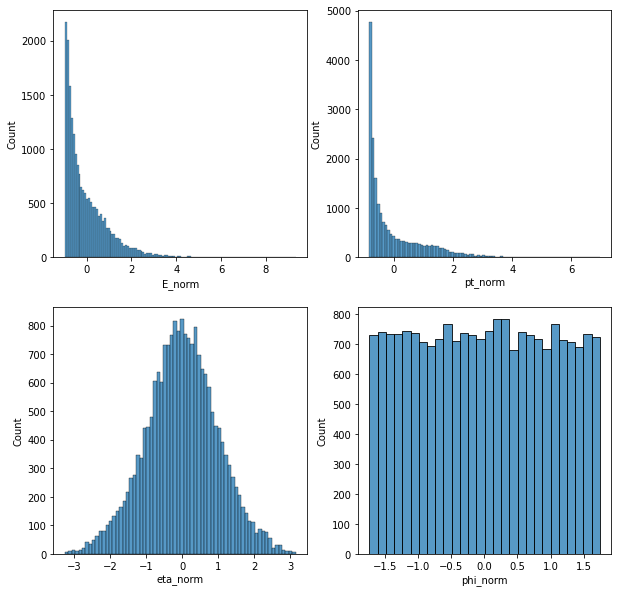

In [11]:
plot_dist(jets_df_train_norm)

Use this standardized data as input to the models.

<h3> Attempt at developing a baseline model using PCA </h3>

In [12]:
pca = PCA(n_components=3)
pca.fit(jets_df_train_norm)

PCA(n_components=3)

This attempt is quickly abandoned, only 92.7% of the variance in the data is captured, which is not good enough for this task.

In [13]:
pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_)

(array([0.42733255, 0.25063843, 0.24923172]), 0.9272026993557286)

<h3> Performance of the exiting autoencoder architecture on this dataset </h3>

In [14]:
train_ds = TensorDataset(torch.Tensor(jets_df_train_norm.values))
val_ds = TensorDataset(torch.Tensor(jets_df_val_norm.values))

In [15]:
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=256)

The existing autoencoder architecture taken from [here](https://github.com/ATLAS-Autoencoders-GSoC-2021/Evaluation-Exercise/blob/main/TLA_4D_Example.ipynb).

In [16]:
class AE(nn.Module):
    def __init__(self, n_features=4, bottleneck_size=3):
        super(AE, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, bottleneck_size)
        
        self.de1 = nn.Linear(bottleneck_size, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

Performance of the autoencoder on the given dataset, after training for 100 epochs

100%|██████████| 100/100 [01:50<00:00,  1.11s/it]


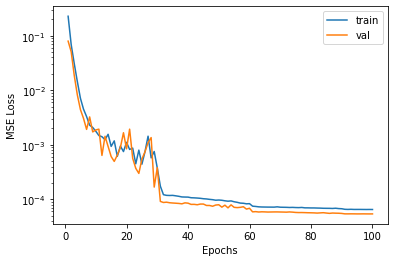

Final train loss = 6.523051686144755e-05, final val loss = 5.417186831538048e-05


In [17]:
net_ae = AE(n_features=4, bottleneck_size=3)

''' train is a utility function for training models. For the time being, the optimizer,
scheduler and loss function are hardcoded. The Adam optimizer is used, with an initial 
learning rate of 1e-3 and lowered by a factor of 10 every 30 epochs.'''

train_losses, val_losses = train(net_ae, train_dl, val_dl, epochs=100, verbose=False)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.plot(range(1, 100+1), train_losses, label="train")
plt.plot(range(1, 100+1), val_losses, label="val")
plt.legend()
plt.show()
print(f"Final train loss = {train_losses[-1]}, final val loss = {val_losses[-1]}")

Analyze performance on the validation set

In [18]:
val_preds = []
with torch.no_grad():
    for batch in val_dl:
        val_preds.append(net_ae(batch[0]))
val_preds = torch.vstack(val_preds)
val_preds_unnormalized = scaler.inverse_transform(val_preds)

<h3> Analysis of Results </h3>

Comparing the distributions of the validation set and the outputs of the autoencoder, they are seen to match reasonably well.

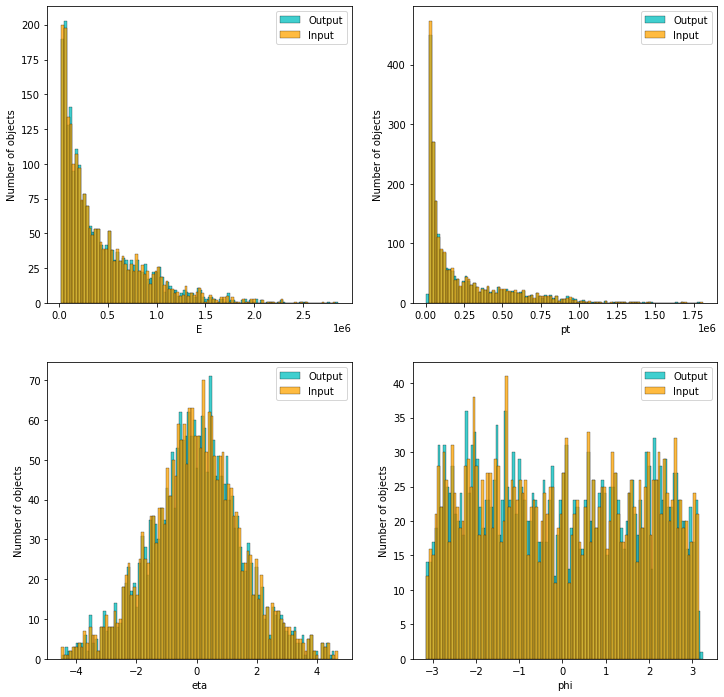

In [19]:
compare_input_output(jets_df_val.values, val_preds_unnormalized)

Calculating the relative difference between the inputs and outputs of the autoencoder: $(output-input)/input$

In [20]:
val_residuals = (val_preds_unnormalized-jets_df_val.values)/jets_df_val.values

Some residuals are of high magnitude because of the low absolute value of the $input$ in the denominator. These entries are removed so as to more easily analyze the correlation, if any, between the residuals of the different variables.

In [21]:
val_residuals_without_outliers = remove_outliers(val_residuals, num_to_remove=5)

In [22]:
print(f"{len(val_residuals_without_outliers)/len(jets_df_val)*100}% of the data is retained") 

98.23555359505956% of the data is retained


It is seen that except in the case of $E$ and $p_{T}$ (which were seen to be correlated), reconstruction is rarely inaccurate for more than one variable.

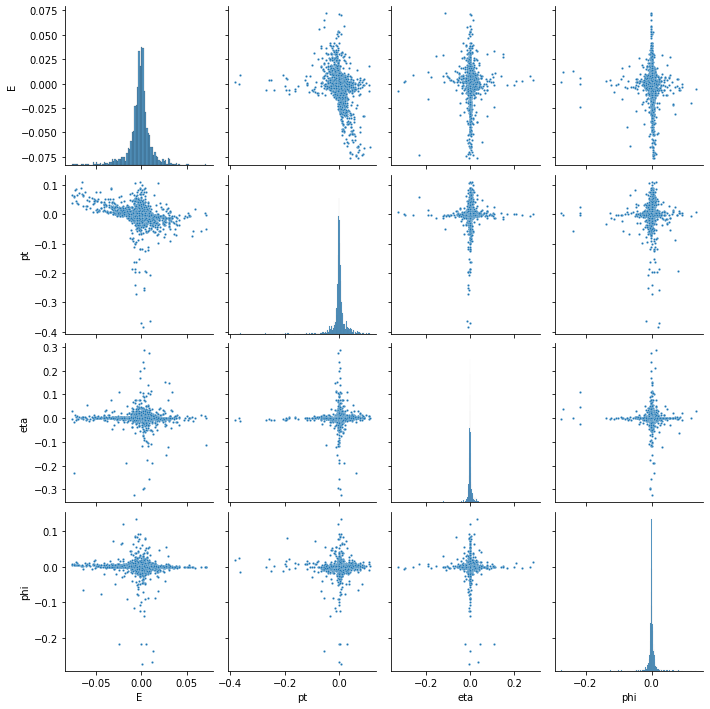

In [23]:
#correlation between the residuals
val_residuals_df = pd.DataFrame(val_residuals_without_outliers, columns=['E', 'pt', 'eta', 'phi'])
sns.pairplot(pd.DataFrame(val_residuals_df), kind="scatter", diag_kind="hist", plot_kws={'s':5})

<h3>Potential areas for improvement</h3>

One possible way to improve performance might be to add skip connections in the encoder and decoder parts of the network. This allows easier flow of gradients and makes the loss landscape easier to optimize.

The overall architecture is the same as the one above, except changing 20 to 200 in the last and first layers of the encoder and decoder respectively, and adding skip connections where possible.

In [24]:
class AE_skip(nn.Module):
    def __init__(self, n_features=4, bottleneck_size=3):
        super(AE_skip, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 200)
        self.en4 = nn.Linear(200, bottleneck_size)
        
        self.de1 = nn.Linear(bottleneck_size, 200)
        self.de2 = nn.Linear(200, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        enc1 = self.tanh(self.en1(x)) 
        enc2 = self.tanh(self.en2(enc1))
        
        enc3 = self.tanh(self.en3(enc1+enc2))
        enc4 = self.en4(enc1+enc2+enc3)
        
        return enc4

    def decode(self, x):
        dec1 = self.tanh(self.de1(x)) 
        dec2 = self.tanh(self.de2(dec1))
        
        dec3 = self.tanh(self.de3(dec1+dec2)) 
        dec4 = self.de4(dec1+dec2+dec3)
        
        return dec4

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

Performance is similar to the original encoder, when the data is being compressed to 3 dimensions.

100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


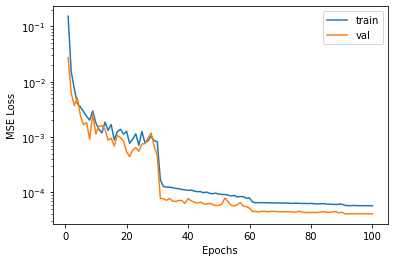

Final train loss = 5.760825729339558e-05, final val loss = 4.0981351857125344e-05


In [25]:
net_ae_skip = AE_skip(n_features=4, bottleneck_size=3)
train_losses, val_losses = train(net_ae_skip, train_dl, val_dl, epochs=100, verbose=False)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.plot(range(1, 100+1), train_losses, label="train")
plt.plot(range(1, 100+1), val_losses, label="val")
plt.legend()
plt.show()
print(f"Final train loss = {train_losses[-1]}, final val loss = {val_losses[-1]}")

However, the performance of the autoencoder with skip connections is better when the dimension of the latent space is lower. Using models with skip connections might improve the compression factor when the number of variables is larger (27, when more variables are used to describe the jets?), or the network is deeper.

100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


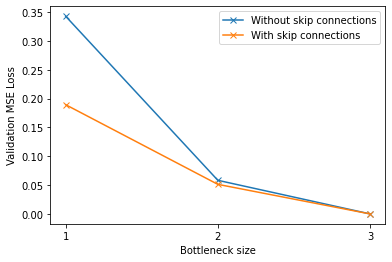

In [26]:
val_loss_ae = []
val_loss_ae_skip = []
for bottleneck in [1, 2, 3]:
    net = AE(n_features=4, bottleneck_size=bottleneck)
    _, val_losses = train(net, train_dl, val_dl, epochs=100, verbose=False)
    val_loss_ae.append(val_losses[-1])

for bottleneck in [1, 2, 3]:
    net = AE_skip(n_features=4, bottleneck_size=bottleneck)
    _, val_losses = train(net, train_dl, val_dl, epochs=100, verbose=False)
    val_loss_ae_skip.append(val_losses[-1])
    
plt.ylabel("Validation MSE Loss")
plt.xlabel("Bottleneck size")
plt.plot([1, 2, 3], val_loss_ae, 'x-', label="Without skip connections")
plt.plot([1, 2, 3], val_loss_ae_skip, 'x-', label="With skip connections")
plt.xticks([1, 2, 3])
plt.legend()
plt.show()

Another concern with the use of autoencoders for reconstruction is that noisy data cannot be easily detected. This effect is seen below.

In [27]:
# minimum and maximum values of variables in the validation set
print("Max values\n", jets_df_val_norm.max(), "\n\nMin values\n", jets_df_val_norm.min())

Max values
 E_norm      5.612876
pt_norm     5.915137
eta_norm    3.111865
phi_norm    1.740037
dtype: float64 

Min values
 E_norm     -0.959874
pt_norm    -0.823756
eta_norm   -3.003106
phi_norm   -1.729955
dtype: float64


In [28]:
#artificial noisy entry with absolute values for each variable larger than those seen in the dataset
noisy_entry = [[6., -1., 3.5, -2.]]

The outputs of the autoencoder are much more in line with the true samples, making it difficult to identify as a noisy outlier. Methods need to be developed to deal with this. One potential way is to develop a standalone model to identify noisy entries, before compressing using the autoencoder.

In [29]:
with torch.no_grad():
    ans = net_ae(torch.Tensor(noisy_entry))
print(ans)

tensor([[ 5.6026, -0.5413,  2.7874, -1.4580]])
